#### CHAPTER 7
# 앙상블 학습과 랜덤 포레스트

1. 투표 기반 분류기 
2. 배깅과 페이스팅
3. 랜덤 패치와 랜덤 서브스페이스
4. 랜덤 포레스트
5. 부스팅
6. 스태킹

##### 앙상블 학습(ensemble learning)
: 학습 알고리즘들을 따로 쓰는 경우에 비해 더 좋은 예측 성능을 얻기위해 다수의 학습 알고리즘을 사용하는 방법
- 여러 개의 분류기를 생성하고, 그 예측을 결합함으로써 보다 정확한 예측을 도출
- 강력한 하나의 모델을 사용하는대신 보다 약한 모델 여러개를 조합하여 더 정확한 예측에 도움을 줌
- 예를 들면, 어려운 문제를 해결하는데 한 명의 전문가보다 여러명의 집단지성을 이용하여 문제를 해결하는 방식

앙상블 학습 유형<br>
: 앙상블 학습은 일반적으로 보팅(Voting), 배깅(Bagging), 부스팅(Boosting) 세 가지 유형과 추가로 스태킹(stacking) 유형이 있음

##### 랜덤 포레스트(random forest)
: 결정 트리의 앙상블 머신러닝 모델
- 여러개의 decision tree를 형성하고 새로운 데이터 포인트를 각 트리에 동시에 통과시키며, 각 트리가 분류한 결과에서 투표를 실시하여 가장 많이 득표한 결과를 최종 분류 결과로 선택


## 투표 기반 분류기 

#### 직접 투표 분류기
: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하도록 다수결 투표로 정해지는 분류기
- 정확도가 높음
- voting="hard" 

* 약한 학습기: 랜덤 추측보다 조금 더 높은 성능을 내는 분류기 
* 강한 학습기: 높은 정확도를 내는 분류기


In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

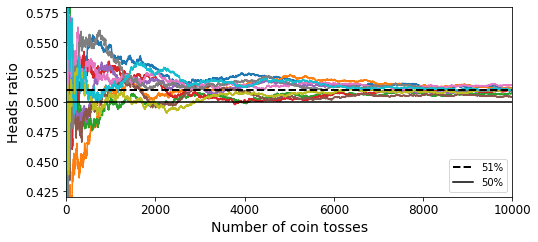

In [2]:
#p247 그림 7-3 큰 수의 법칙
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [3]:
#여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons #5장에서 사용했던 moons 데이터셋

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

#### 간접 투표
: 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 것
- 확률이 높은 투포에 비중을 더 주기 때문에 직접 투표 방식보다 성능이 높음
- voting="soft" 

In [6]:
#간접 투표
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) #SVC는 기본값에서는 클래스 확률을 제공하지 않음 -> probability=True 지정

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


- 직접 투표 분류기를 사용했을 때보다 정확도 상승

## 배깅과 페이스팅
- 같은 알고리즘을 사용하나 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 다르게 학습시키는 것
- 즉, 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능

#### 배깅
: 훈련 세트에서 중복을 허용하여 샘플링하는 방식

#### 페이스팅
: 중복을 허용하지 않고 샘플링 하는 방식

수집함수
- 분류: 통계적 최빈값(=가장 많은 예측 결과) 계산
- 회귀: 평균을 계산

### 사이킷런의 배깅과 페이스팅
- 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier, BaggingRegresssor 제공

In [8]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
# 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련
# 배깅
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, random_state=42) 
    #bootstrap=True:배깅 bootstrap=False: 페이스팅
    #n_jobs=-1 : 훈련과 예측에 사용한 CPU코어 수를 지정; 모든 코어 사용;
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
#단일 결정 트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [10]:
#p251 그림7-5
#단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계 비교
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

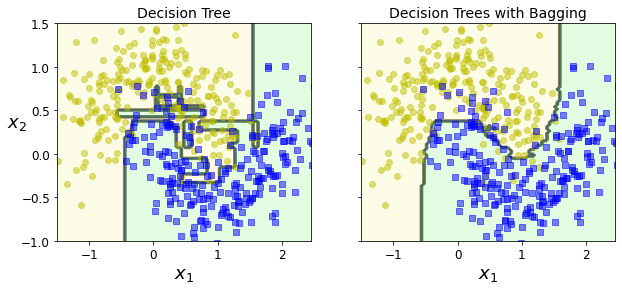

In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 잘 되었음
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦
- 즉, 훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함
- 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

### oob 평가
* 배깅을 사용한 경우, 어떤 샘플은 여러번 샘플링되고, 어떤 샘플은 한번도 선택되지 않을 수 있음

이때, 선택되지 않은 훈련 샘플(약 37%)를 oob 샘플이라고 부름
- oob_score=True 로 지정시, 훈련이 끝난 후 자동으로 oob 평가 수행; 결과는 oob_score_ 변수에 저장됨

In [12]:
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, oob_score=True, random_state=42)
bag_clf_oob.fit(X_train, y_train)
bag_clf_oob.oob_score_ #oob_score

0.9253333333333333

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred)) #테스트 세트에서의 정확도

0.904


In [14]:
bag_clf_oob.oob_decision_function_

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.01030928, 0.98969072],
       [0.03174603, 0.96825397],
       [0.07672634, 0.92327366],
       [0.39189189, 0.60810811],
       [0.06145251, 0.93854749],
       [0.92689295, 0.07310705],
       [0.88205128, 0.11794872],
       [0.59850374, 0.40149626],
       [0.04896907, 0.95103093],
       [0.7565445 , 0.2434555 ],
       [0.81377551, 0.18622449],
       [0.88528678, 0.11471322],
       [0.07407407, 0.92592593],
       [0.04738155, 0.95261845],
       [0.92051282, 0.07948718],
       [0.69974555, 0.30025445],
       [0.94358974, 0.05641026],
       [0.06100796, 0.93899204],
       [0.224     , 0.776     ],
       [0.9125964 , 0.0874036 ],
       [0.98746867, 0.01253133],
       [0.95967742, 0.04032258],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.03466667, 0.96533333],
       [0.7020202 , 0.2979798 ],
       [0.

- oob 샘플에 대한 결정 함수의 값
- 결정 함수는 각 훈련 샘플의 클래스 확률을 반환함
- 예를 들어, 첫 번째 훈련 샘플이 양성 클래스에 속할 확률은 64.4%, 음성 클래스에 속할 확률은 35.5%로 추정

## 랜덤 패치와 랜덤 서브스페이스
특성 샘플링
- max_features, bootstrap_features 두 매개변수로 조절됨
- 특성에 대한 샘플링
- 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련
- 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

#### 랜덤 패치
: 훈련 특성과 샘플을 모두 샘플링 하는 것

#### 랜덤 서브스페이스
: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것
- bootstrap=False, max_samples=1.0, bootstrap_features=True, max_features=1보다 작게 설정

## 랜덤 포레스트
: 배깅(또는 페이스팅) 방법을 적용한 결정 트리의 앙상블
- max_samples: 훈련 세트의 크기

In [15]:
# 500개의 트리로 이루어진 랜덤 포레스트 분류기를 훈련시킴
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [16]:
#BaggingClassifier.vsr
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

### 엑스트라 트리
: 극단적으로 무작위한 트리의 랜덤 포레스트; 익스트림 랜덤 트리;
- 일반적인 랜덤 포레스트보다 빠름

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

etr_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
etr_clf.fit(X_train, y_train)

y_pred_rf = etr_clf.predict(X_test)
#ExtraTreesRegressor도 RandomForestRegressor과 같은 API 제공

In [18]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일

0.96

### 특성 중요도
: 랜덤 포레스트의 장점중 하나로, 특성의 상대적 중요도로 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플의 수와 같음
- feature_importances_ 변수에 자동으로 저장됨

In [19]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score) #특성 중요도 출력

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [20]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [25]:
# MNIST 데이터셋에 랜덤 포레스트 분류기 훈련
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

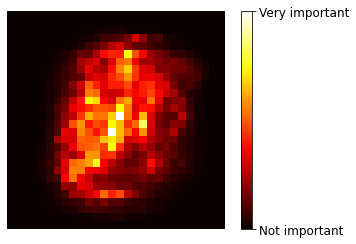

In [28]:
# 랜덤 포레스트 분류기에서 얻은 MNIST 픽셀 중요도
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 부스팅
: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나가면서 일련의 예측기 학습
- 에이다부스트/그레이디언트 부스팅 두 방법

### 에이다부스트
: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 새로운 예측기를 학습하기 어려운 샘플에 점점 더 맞추는 방식
* 동작 과정
![nn1](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile2.uf.tistory.com%2Fimage%2F995BC6475BA798440EF99F)

![nn2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile25.uf.tistory.com%2Fimage%2F998937475BA798450A74A0)

In [29]:
# AdaBoostClassifier 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기 훈련
# 결정 트리 max_depth=1
# AdaBoostClassifier의 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

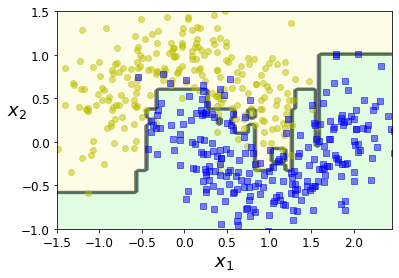

In [30]:
plot_decision_boundary(ada_clf, X, y)

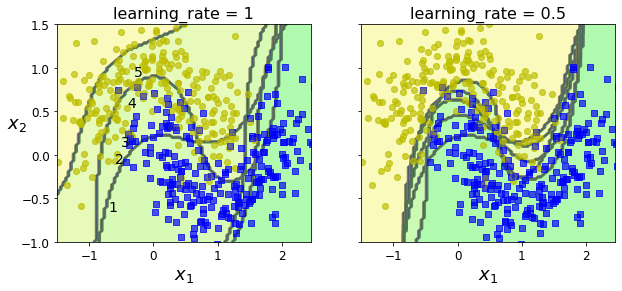

In [31]:
# moons 데이터셋
# 다섯 개의 연속된 예측기의 결정 경계
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

- 분류기가 한 예측이 점점 좋아짐
- 경사하강법과 비슷
- 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이타부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가
- 예측기마다 다른 가중치 적용 

### 그레이디언트 부스팅
: 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가, 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습
- 그레이디언트 트리 부스팅/ 그레이디언트 부스티드 회귀트리(GBRT)

In [34]:
# 잡음이 섞인 2차 곡선 형태의 훈련 세트 학습
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [35]:
#예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
# 두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
X_new = np.array([[0.8]]) #새로운 샘플

In [40]:
# 새로운 샘플에 대한 예측
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)) # 모든 트리의 예측을 더함
y_pred

array([0.75026781])

In [42]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

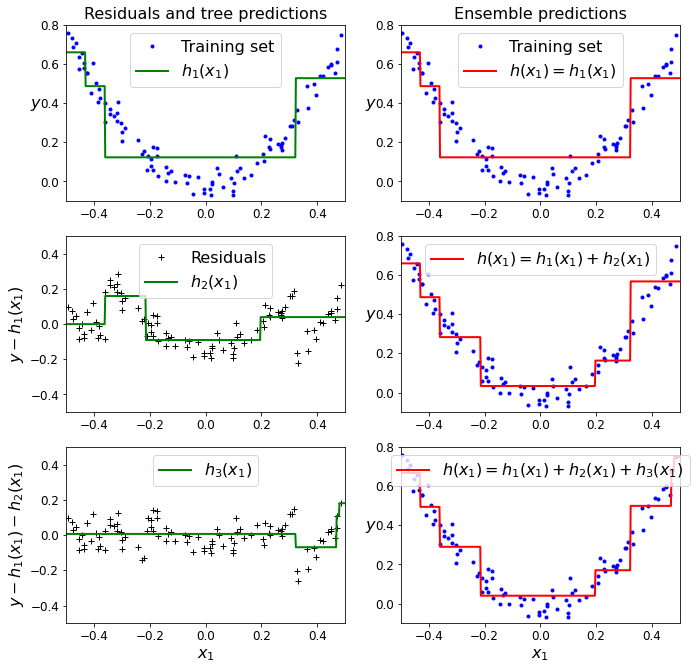

In [43]:
# 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- 왼쪽 그림 순서(위->아래)대로 첫번째 예측기, 두번쨰 예측기, 세번째 예측기
- 이전 예측기의 잔여 오차에서 훈련 되어 점점 예측이 좋아지는 것(오른쪽 그림)을 확인할 수 있음

**매개변수**
- n_estimators: 앙상블의 훈련을 제어
- max_depth, min_samples_leaf: 결정 트리의 성장 제어와 관련
- subsample: 사용할 훈련 샘플의 비율 지정

In [45]:
# 규제 방법 - 축소
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
    #learning_rate: 각 트리의 기여도 정도 조절
    # 0.1 처럼 낮게 설정하면 훈련을 위해 많은 트리가 필요하지만 예측의 성능은 좋아짐

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [46]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

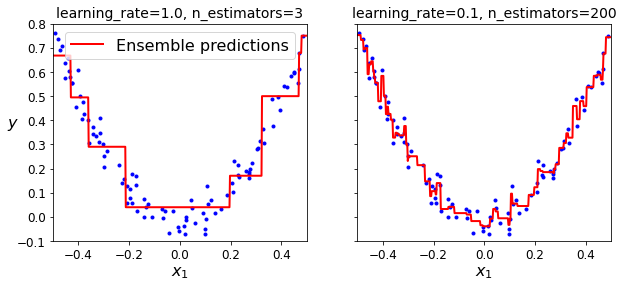

In [47]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 왼쪽 그림은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합이 일어남
- 그렇다면 최적의 트리 수는 무엇인가?

#### 최적의 트리수
* staged_predict(): 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환

In [48]:
#조기 종료를 사용한 그래디언트 부스팅
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] #최적의 트리수 이용
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [49]:
min_error = np.min(errors)

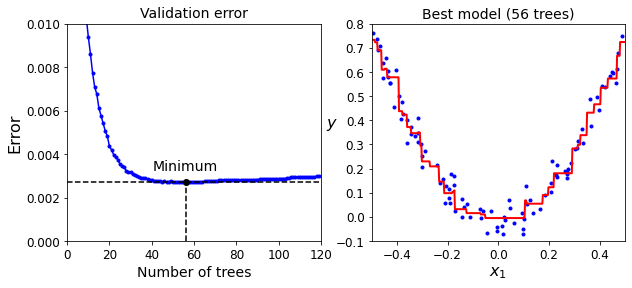

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 조기종료를 사용하여 트리수를 튜닝
- 왼쪽 그림은 검증의 오차, 오른쪽 그림은 최적 모델의 예측

In [51]:
#연소해서 다섯번의 반복 동안 검증 오차가 향상되지 않으면 훈련ㅇ르 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
    #warm_start=True: fit() 메서드가 호출될 떄 기존 트리를 유지하고 훈련을 ㅊ푸가할 수 있도록 해줌
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [52]:
print(gbrt.n_estimators) #최적의 트리수

61


In [53]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


In [54]:
#XGBoost
#최적화된 그레이디언트 부스팅 구현
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [55]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)         

Validation MSE: 0.004000408205406276


In [56]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2) #자동 조기 종료
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)          

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


In [57]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

37.3 ms ± 813 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

17.4 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 스태킹
: 앙상블에 속한 모든 예측기의 예측을 취합하는 모델을 훈련시키는 방식; 사이킷런에서 직접 지원X

블렌더
- 여러 예측기의 값들을 입력으로 받아 최종 예측을 만듦
- 즉, 마지막 예측기
- 홀드 아웃 세트 사용

#### 홀드 아웃 세트 p268-271
![nn3](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FDj6MH%2FbtqBBfNGIcX%2FGW7wAmFMe6k06W3CXqQyKK%2Fimg.jpg)
- 데이터를 일정량 테스트 세트로 분류, 남은 데이터로 훈련하고 테스트 데이터를 사용함

In [59]:
#연습문제 9번; 스태킹 실습

문제: 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.

In [67]:
#문제 8번
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)


estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]

from sklearn.ensemble import VotingClassifier
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [70]:
####
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [71]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [72]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [73]:
rnd_forest_blender.oob_score_

0.9688

- 이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, MLPClassifier)를 시도해 볼 수 있음
- 다음 교차 검증을 사용해 가장 좋은 것을 선택

블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?

In [74]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [75]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [76]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9668